For this notebook you need to install:

- `tensorflow`
- `keras`
- `keras-vis`

The easiest way is to first install the `anaconda` distribution for `python` (preferably `Python 3`) and then use in a terminal

    conda install pip
 
`pip` is the python package installation tool. Then, you can simply use

    pip install tensorflow
    pip install keras
    pip install keras-vis

which should install everything easily.

The `numpy` library does some expensive operations outside Python using efficient code (Fortran, C/C++). However, switching back to python after each operation cause a big overhead because of unnecessary copies of the data. 

The library `tensorflow` does all the computations outside of Python: the python API is used to define a graph of operations, that will run entirely using C++ binaries. This architecture allows to get rid of the overhead. Besides, knowing the computational graph beforehand allows to parallelize and/or distribute the computation more easily. As a result, `tensoflow` can run the computations on multiple CPUs or GPUs, and on multiple servers.

However, for quick an easy model prototying, the library `keras` is simpler to use than `tensorflow`. 
Deep learning models can be constructed thanks to `keras` in few lines of python. So in this notebook, we won't see direct calls to `tensorflow`, but only to `keras`, even if the computations are done by `tensorflow`.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle as pkl
import os

import tensorflow
import keras
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import activations

from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

print("tensorflow version %s (should be at least 0.12.1)" % tensorflow.__version__)
print("keras version %s (should be at least 2.0.7)" % keras.__version__)

Using TensorFlow backend.


tensorflow version 2.0.0 (should be at least 0.12.1)
keras version 2.3.1 (should be at least 2.0.7)


### <font color=darkred> Handwritten digit recognition with MNIST</font>

For the first part of this tutorial, we will use the [MNIST](http://yann.lecun.com/exdb/mnist) dataset.
This dataset contains images representing handwritten digits. 
Each image is 28 x 28 pixels, and each pixel is represented by a number (gray level). 
These arrays can be flattened into vectors of 28 x 28 = 784 numbers.
You can then see each image as a point in a 784-dimensional vector space. 
You can find interesting visualisations of this vector space [http://colah.github.io/posts/2014-10-Visualizing-MNIST/](http://colah.github.io/posts/2014-10-Visualizing-MNIST/).

The labels in $\{0, 1, 2, \ldots, 9\}$ giving the digit on the image are be represented using one-hot encoding: labels in $\{0, 1, 2, \ldots, 9\}$ are replaced by labels in $\{ 0, 1\}^{10}$, namely $0$ is replaced by $(1, 0, \ldots 0)$, $1$ is replaced by $(0, 1, 0, \ldots 0)$, $2$ is replaced by $(0, 0, 1, 0, \ldots, 0)$, etc.

Also, MNIST data is grayscale pixels in $\{0, \ldots, 255\}$. The pixels should be normalized to belong to $[0, 1]$.
Indeed, working with big floats can lead to important numerical errors, in particular in deep learning models.

MNIST is a very old and standard benchmark dataset for image classification, so it's built-in (ready to be downloaded) in all machine learning libraries (including `keras` and `tensorflow`).

In [9]:
# Number of classes
num_classes = 10
# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train)
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
y_train shape: (60000,)
y_test shape: (10000,)
60000 train samples
10000 test samples


In the next cell we illustrate the first for elements of the training data: 
pixels grayscale of the digit and their corresponding label.

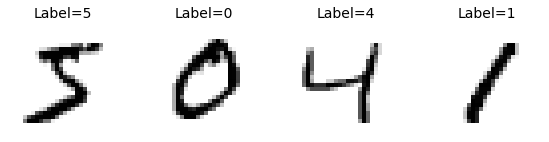

In [4]:
plt.figure(figsize=(8, 2))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(x_train[i].reshape(28, 28), 
               interpolation="none", cmap="gray_r")
    plt.title('Label=%d' % y_train[i], fontsize=14)
    plt.axis("off")
plt.tight_layout()

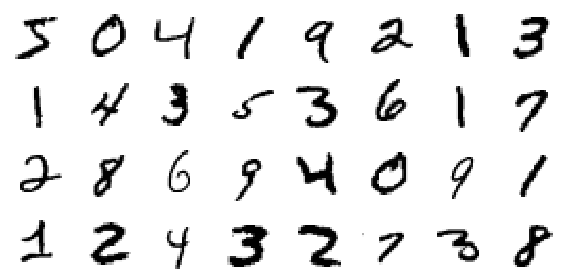

In [57]:
n_rows = 4
n_cols = 8
plt.figure(figsize=(8, 4))
for i in range(n_rows * n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    plt.axis("off")
plt.tight_layout()

The first character is a 5 digit, encoded in grayscale matrix.

We need to normalize the images and one-hot encode the labels.

In [8]:
x_train /= 255
x_test /= 255

In [4]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_train[:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], dtype=float32)

### <font color=darkred> Softmax regression for MNIST</font>

Logistic regression can be extended to classify data in more than two groups. Softmax regression provides a model for the probability that an input $x$ is associated with each group.  It is assumed that the probability to belong to the class $k\in\{1,\ldots,M\}$ can be expressed by 
\begin{equation*}
\mathbb{P}(Y = k| X) = \frac{\exp(\langle w_k,X \rangle + b_k)}{\sum_{\ell=1}^{M}\exp(\langle w_\ell,X \rangle + b_\ell)} = p_k(X)\,,
\end{equation*}
where $w_\ell \in \mathbb{R}^d$ and $b_\ell$  are model `weights` and `intercepts` for each class.


To estimate these unknown parameters, a maximum likelihood approach is used as in the logistic regression setting. In this case, the loss function is given by the negative log-likelihood (see also the section on gradient based method).

To train the model weights $W_{k, j}$ and $b_k$ for $k=1, \ldots, 10$ and $j=1, \ldots, 784$, we consider the loss function given by the negative log-likelihood.
For the considered model, the negative log-likelihood of a sample with input $x_i \in \mathbb R^{784}$ and label $y_i \in \{0, 1\}^{10}$, it is given by the cross-entropy between the scores $p_k(x_i)$ and the label $y_i$:
$$
- \sum_{k=1}^{10} y_{i, k} \log(p_k(x_i))
$$
For this first model, we will simply use stochastic gradient descent over small batches of data. It can be done easily with TensorFlow, as it will automatically and efficiently compute the gradient from your graph, then apply an optimization algorithm of your choice to perform the parameters update.

In [60]:
def modelling():
    model = Sequential()
    # First we need to flatten the data: replace 28 * 28 matrices by flat vectors
    # This is always necessary before feeding data to a fully-connected layer (Dense object)
    model.add(Flatten(input_shape=input_shape, name='flatten'))

    model.add(Dense(num_classes, activation='softmax', name='dense_softmax'))

    model.compile(
    # specify the loss as the cross-entropy
    loss=keras.losses.categorical_crossentropy,
    # choose the Adagrad solver, but you can choose others
    optimizer=keras.optimizers.Adagrad(),
    # to monitor the accuracy on a testing set along optimization
    metrics=['accuracy']
    )
    #model.summary() 
    return model

In [61]:
batch_size = 64
epochs = 50

# Run the train
model = modelling()
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.4936 - accuracy: 0.8747 - val_loss: 0.3649 - val_accuracy: 0.9036
Epoch 2/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.3627 - accuracy: 0.9012 - val_loss: 0.3330 - val_accuracy: 0.9099
Epoch 3/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.3382 - accuracy: 0.9074 - val_loss: 0.3180 - val_accuracy: 0.9138
Epoch 4/50
60000/60000 [==============================] - 1s 16us/step - loss: 0.3250 - accuracy: 0.9110 - val_loss: 0.3089 - val_accuracy: 0.9144
Epoch 5/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.3164 - accuracy: 0.9130 - val_loss: 0.3034 - val_accuracy: 0.9156
Epoch 6/50
60000/60000 [==============================] - 1s 15us/step - loss: 0.3101 - accuracy: 0.9143 - val_loss: 0.2990 - val_accuracy: 0.9163
Epoch 7/50
60000/60000 [==============================] - 1s 15us/st

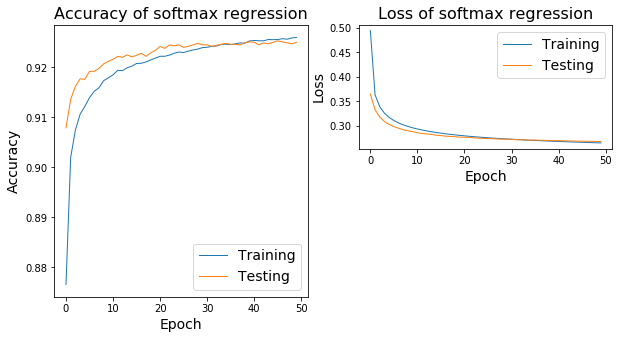

In [35]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.plot(history.epoch, history.history['accuracy'], lw=1, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=1, label='Testing')
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=14)

plt.subplot(222)
plt.plot(history.epoch, history.history['loss'], lw=1, label='Training')
plt.plot(history.epoch, history.history['val_loss'], lw=1, label='Testing')
plt.title('Loss of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)

plt.legend(fontsize=14)


plt.tight_layout()

![](optimal_epochs.PNG)

The batch size is fixed to 64. This only aims at finding an optimal number of epochs. So the optimal number of epochs seems to be 30 epochs. Beyond this number, the gain in accuracy increases and the loss keeps decreasing, but it seems to reach a limit and this improvement is poor comparing to the cost of computing such a high number of epochs. Then, we are going to estimate the optimal batch size with the gridsearch methods with a number of epochs in a small range around 30. 

**Question**

Run a cross-validation to analyze the influence of the number of epochs and the batch-size.

In [36]:
def modelling():
    model = Sequential()
    model.add(Flatten(input_shape=input_shape, name='flatten'))
    model.add(Dense(num_classes, activation='softmax', name='dense_softmax'))
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adagrad(),
        metrics=['accuracy'])
    return(model)

est = KerasClassifier(build_fn=modelling)      

parameters = {
    'batch_size': [8, 16, 32, 64, 128, 256, 512],
    'epochs': [20, 30, 40]}

gr_sr = GridSearchCV(         #GridSearchCV considers all hyper-parameters combinations
    estimator=est,
    param_grid=parameters,
    n_jobs=-1,     #means that use all available computing power
    cv=3,)         #number of folds for cross validation
    

gr_sr.fit(x_train,y_train) 

Epoch 1/40
60000/60000 [==============================] - 2s 33us/step - loss: 0.4576 - accuracy: 0.8831
Epoch 2/40
60000/60000 [==============================] - 2s 28us/step - loss: 0.3506 - accuracy: 0.9047 1s - loss: 0.3587 - ac - ETA: 0s - los
Epoch 3/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.3299 - accuracy: 0.9098
Epoch 4/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.3187 - accuracy: 0.9123
Epoch 5/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.3111 - accuracy: 0.9144
Epoch 6/40
60000/60000 [==============================] - 2s 28us/step - loss: 0.3058 - accuracy: 0.9155
Epoch 7/40
60000/60000 [==============================] - 2s 27us/step - loss: 0.3014 - accuracy: 0.9168
Epoch 8/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.2980 - accuracy: 0.9173
Epoch 9/40
60000/60000 [==============================] - 2s 27us/step - loss: 0.2950 - accuracy: 0.9184
Epoch 10/40
6000

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1a55022b90>,
             iid='warn', n_jobs=-1,
             param_grid={'batch_size': [16, 32, 64], 'epochs': [30, 40]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [10]:
print("The best parameters found are the following ones:")
print(gr_sr.best_params_)


The best parameters found are the following ones:


NameError: name 'gr_sr' is not defined

![](optimal.PNG)

We have also the curves that show the influence of the batch size:

![](image1.PNG)
![](image2.PNG)
![](image3.PNG)
![](image4.PNG)
![](image5.PNG)
![](image6.PNG)


Weight matrices plots show that the learned weights are consistant with the digits they should predict (see below).
You should be able to see rough shapes corresponding to the digits 0, 1, 2, 3, etc.

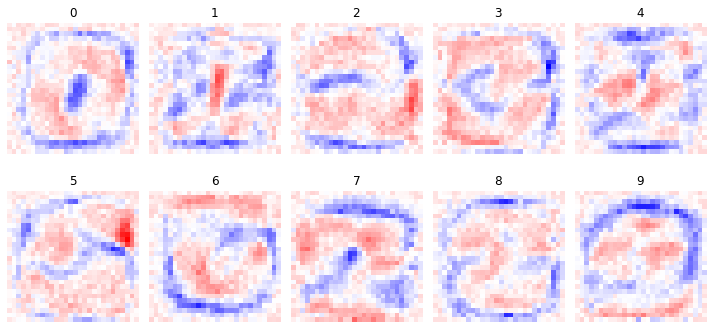

In [62]:
best_model = gr_sr.best_estimator_.model
weights, biases = best_model.get_layer('dense_softmax').get_weights()
imgs = weights.reshape(28, 28, 10)

fig = plt.figure(figsize=(10, 5))
vmin, vmax = imgs.min(), imgs.max()
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    im = imgs[:, :, i]
    mappable = ax.imshow(im, interpolation="nearest", 
                         vmin=vmin, vmax=vmax, cmap='bwr')
    ax.axis('off')
    ax.set_title("%i" % i)
plt.tight_layout()

In [63]:
del model, est, gr_sr, best_parameters

### <font color=darkred> Feed-Forward Neural Network (FFNN)</font>

The softmax regression you just trained is a linear model, with 7850 parameters. 
It is easy to fit, numerically stable, but might be too simple for some tasks. 
The idea behind neural networks is to have a nonlinear model, while keeping the nice features of linear ones. 
The idea is to keep parameters into linear functions, and link these small linear model using non linear operations.

A simple nonlinearity which is often used to do this is the rectified linear unit
$\text{ReLU}(x) = \max(0, x)$

The derivative of this function is very easy to compute, and it is parameter-free. If we stack models such as softmax regression and ReLUs, it is still very easy to compute the gradient using the chain rule, as the model is a combination of simple functions.

The backpropagation algorithm allows efficient computation of complex derivatives as long as the function is made of simple blocks with simple derivatives. 
This algorithm efficiency is based on data reuse: when working with parallel architectures such as GPUs, you want to minimize communication (data transfer) as it is very time consuming in comparison to the computing time.

**Question**

Create the graph for a fully connected feed-forward neural network with one hidden layer with 128 units and a relu activation function. 

In [83]:
model_ffnn = Sequential()

model_ffnn.add(Flatten(input_shape=input_shape))
###
model_ffnn.add(Dense(128, activation='relu'))
###
model_ffnn.add(Dense(num_classes, activation='softmax'))

model_ffnn.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adagrad(),
    metrics=['accuracy']
)

model_ffnn.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_13 (Dense)             (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [84]:
batch_size = 32
epochs = 10

# Run the train
history = model_ffnn.fit(x_train, y_train,
                         batch_size=batch_size,
                         epochs=epochs,
                         verbose=1,
                         validation_data=(x_test, y_test))
score = model_ffnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s 51us/step - loss: 0.2654 - accuracy: 0.9248 - val_loss: 0.1837 - val_accuracy: 0.9489
Epoch 2/10
60000/60000 [==============================] - 3s 54us/step - loss: 0.1638 - accuracy: 0.9549 - val_loss: 0.1461 - val_accuracy: 0.9581
Epoch 3/10
60000/60000 [==============================] - 3s 55us/step - loss: 0.1357 - accuracy: 0.9623 - val_loss: 0.1299 - val_accuracy: 0.9617
Epoch 4/10
60000/60000 [==============================] - 3s 51us/step - loss: 0.1192 - accuracy: 0.9671 - val_loss: 0.1207 - val_accuracy: 0.9647
Epoch 5/10
60000/60000 [==============================] - 3s 53us/step - loss: 0.1076 - accuracy: 0.9704 - val_loss: 0.1134 - val_accuracy: 0.9670
Epoch 6/10
60000/60000 [==============================] - 3s 52us/step - loss: 0.0987 - accuracy: 0.9725 - val_loss: 0.1095 - val_accuracy: 0.9674
Epoch 7/10
60000/60000 [==============================] - 3s 50us/st

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['accuracy'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_accuracy'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

**Question**

Run a cross-validation to analyze the influence of the the number of units of the hidden layer, the number of epochs and the batch-size.

In [9]:
def modelling_ffnn(nb_neuron = 128):
    model = Sequential()
    model.add(Flatten(input_shape=input_shape))
    model.add(Dense(nb_neuron, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adagrad(),
        metrics=['accuracy'])
    return(model)

parameters = {
    'nb_neuron': [128, 256, 512],
    'batch_size': [16, 32, 64],
    'epochs': [20, 30]}

est = KerasClassifier(build_fn=modelling_ffnn)

gr_sh = GridSearchCV(
    estimator= est,
    param_grid=parameters,
    n_jobs=-1,     #means that use all available computing power
    cv=3,)         #number of folds for cross validation
    
gr_sh.fit(x_train,y_train) 



Epoch 1/30
60000/60000 [==============================] - 10s 171us/step - loss: 0.1909 - accuracy: 0.9447
Epoch 2/30
60000/60000 [==============================] - 9s 152us/step - loss: 0.0982 - accuracy: 0.9726
Epoch 3/30
60000/60000 [==============================] - 9s 157us/step - loss: 0.0752 - accuracy: 0.9791
Epoch 4/30
60000/60000 [==============================] - 8s 136us/step - loss: 0.0621 - accuracy: 0.9834
Epoch 5/30
60000/60000 [==============================] - 9s 148us/step - loss: 0.0531 - accuracy: 0.9861
Epoch 6/30
60000/60000 [==============================] - 9s 149us/step - loss: 0.0462 - accuracy: 0.9884
Epoch 7/30
60000/60000 [==============================] - 8s 137us/step - loss: 0.0409 - accuracy: 0.9900
Epoch 8/30
60000/60000 [==============================] - 9s 156us/step - loss: 0.0367 - accuracy: 0.9915
Epoch 9/30
60000/60000 [==============================] - 10s 165us/step - loss: 0.0331 - accuracy: 0.9924
Epoch 10/30
60000/60000 [===================

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x1a495dead0>,
             iid='warn', n_jobs=-1,
             param_grid={'batch_size': [16, 32, 64], 'epochs': [20, 30],
                         'nb_neuron': [128, 256, 512]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [11]:
print("The best parameters found are the following ones:")
print(gr_sh.best_params_)

The best parameters found are the following ones:
{'batch_size': 16, 'epochs': 30, 'nb_neuron': 512}


![](capture.PNG)

### <font color=darkred> Convolutional Neural Networks </font>

In practice, increasing the size of hidden layers is not very effective. 
It is often a better idea to add more layers. 
Intuitively, if the observations have a hierarchical structure, adding more layers can be interpreted as a way to learn more levels of abstraction.  For example, in object detection tasks, it is easier to express shapes from edges and objects from shapes, than to express objects from pixels.  Thus, a good design should try to exploit this hierarchy.

In particular cases, such as grid-like data (time series, images), the observations can depend on a pattern which can be associated with different locations of the data. 
For example, an object can be in the middle or the left of the picture. 
Thus, the model has to be translation invariant: it is easier to learn how to recognize an object independently of its location. 

When two inputs might contain the same kind of information, then it is useful to share their weights and estimate the weights jointly for those inputs to learn statistical invariants (things that don't change much on average across time or space). 
Using this concept on images leads to convolutional neural networks (CNNs), on text, it results on recurrent neural networks (RNNs).  When using CNNs, weights are set to a small kernel that is used to perform a convolution across the image.

In the previous example, the step ``model_ffnn.add(Flatten(input_shape=input_shape))`` destroys the spatial organization of the input but is mandatory before the fully connected step: ``model_ffnn.add(Dense(128, activation='relu'))``. The spatial organization of the input may be preserved before using Flatten by convolution steps such as ``model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))``. This layer has 32 outputs, each of which depending on a 3*3 weight matrix.

Each output neuron of the next layer is computed as follows (image taken from https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/) before computing an elementwise RELU function:
<img src="conv.PNG">

The convolution maps patches of the input image, combined with the convolution kernel, for example
$$
\text{output} = \text{ReLU}(\text{patch} \times W + b)\,.
$$

Performing the convolution between the image and the weight matrix consists in moving the kernel across the image, and to produce an output for each patch. The way you move across the image is defined by two parameters:

- ``Stride``: the stride is the number of pixels you are shifting each time you move your kernel during the convolution.
- ``Padding``: defines what happens when the kernel reaches a border of the image when doing the convolution. 
"Valid" padding means that you stop at the edge, while "Same" padding allows to go off the edge and pad with zeros so that the width and the height of the output and input tensors are the same.

A classical approach is to use a stride of 1 and to combine theoutputs being in some neighborhood. Such an operation combining elements of a tensor is called ``pooling``: ``model_cnn.add(MaxPooling2D(pool_size=(2, 2)))``. Neighborhoods are define by the pooling window dimension (width x height) and the strides you use when moving this window across the image.  Again, a sliding window is applied along the input to produce the output, the most common function applied on each window being the ma function: it aggregates several outputs in a neighborhood $N$ using a max operation: 
$$
\text{output}'_i = \max_{j \in N}\text{output}_j, \quad i \in N.
$$
The formulas to compute the size of the ouput tensor are the same as for convolution padding and striding: (image taken from https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-tensorflow/):
<img src="maxpool.PNG">

In [ ]:
model_cnn = Sequential()

###
model_cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(Flatten(input_shape=input_shape))
model_cnn.add(Dense(num_classes, activation='softmax'))
###
                    
model_cnn.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

model_cnn.summary()

In [ ]:
batch_size = 32
epochs = 5

# Run the train
history = model_cnn.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
score = model_cnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
plt.figure(figsize=(7, 5))
plt.plot(history.epoch, history.history['acc'], lw=3, label='Training')
plt.plot(history.epoch, history.history['val_acc'], lw=3, label='Testing')
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.tight_layout()

### <font color=darkred> notMNIST</font>

MNIST is a very very **clean** dataset. Digits are rescaled, smoothed, centered, and pixel values are normalized beforehand. Let's switch to a slightly harder dataset: [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html).

This time, labels are letters from 'A' to 'J' (10 classes). 
These letters are taken from digital fonts instead of handwriting pictures. 
We will use a reduced amount of data to ensure a reasonable training time. 
The training set you will use has 200K labelled examples, while the validation and test sets both contain 10K labelled examples.

In [ ]:
import urllib

In [ ]:
pickle_file = './notMNIST.pickle'

with open(pickle_file, 'rb') as f:
    data = pkl.load(f)

In [ ]:
data.keys()

In [ ]:
def reshape(x, image_data_format, img_rows, img_cols):
    if image_data_format == 'channels_first':
        return x.astype(np.float32).reshape((-1, 1, img_rows, img_cols))
    else:
        return x.astype(np.float32).reshape((-1, img_rows, img_cols, 1))

img_rows, img_cols = 28, 28
num_labels = 10
image_data_format = K.image_data_format()

if image_data_format == 'channels_first':
    input_shape = (1, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 1)
    
x_train = reshape(data['train_dataset'], image_data_format, img_rows, img_cols)
x_valid = reshape(data['valid_dataset'], image_data_format, img_rows, img_cols)
x_test = reshape(data['test_dataset'], image_data_format, img_rows, img_cols)

y_train = keras.utils.to_categorical(data['train_labels'])
y_valid = keras.utils.to_categorical(data['valid_labels'])
y_test = keras.utils.to_categorical(data['test_labels'])

print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

print(x_train.shape[0], 'training samples')
print(x_valid.shape[0], 'validation samples')
print(x_test.shape[0], 'testing samples')

In [ ]:
# plt.figure(figsize=(8, 4))
n_rows = 10
n_cols = 8
plt.figure(figsize=(n_cols, n_rows))

letters = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
def get_label(y):
    return letters[y.argmax()]

for i in range(n_rows * n_cols):
    ax = plt.subplot(n_rows, n_cols, i+1)
    ax.imshow(x_train[i].reshape(28, 28),
               interpolation="none", cmap="gray_r")
    ax.set_title(get_label(y_train[i]), fontsize=14)
    ax.axis("off")
plt.tight_layout()

**Question**

Train a softmax regression, visualize the weights, plot the convergence curves, save the model and its history (start with a small number of epochs, and increase the number of epochs).

In [ ]:
batch_size = [32]
list_epochs = [2,5,10,30,50]

for nb_epochs in list_epochs:
    for b in batch_size:
      model = Sequential()
      model.add(Flatten(input_shape=input_shape, name='flatten'))
      model.add(Dense(num_classes, activation='softmax', name='dense_softmax'))
      model.compile(
          loss=keras.losses.categorical_crossentropy,
          optimizer=keras.optimizers.Adagrad(),
          metrics=['accuracy']
      )
    
      history = model.fit(x_train, y_train,
                          batch_size=b,
                          epochs=nb_epochs,
                          verbose=1,
                          validation_data=(x_test, y_test))
    
      loss=history.history["loss"]
      acc=history.history["accuracy"]
      val_loss=history.history["val_loss"]
      val_acc=history.history["val_accuracy"]
      
      epochs=np.arange(1, nb_epochs + 1)
    
      plt.figure(figsize=(7, 5))
      plt.plot(epochs, loss, label ="Training")
      plt.plot(epochs, val_loss, label ="Testing")
      plt.legend(fontsize=14)
      plt.title('Loss of softmax regression, batch_size = ' + str(b), fontsize=16)
      plt.xlabel('Epoch', fontsize=14)
      plt.ylabel('Loss', fontsize=14)
    
    
      plt.figure(figsize=(7, 5))
      plt.plot(epochs, acc, label ="Training")
      plt.plot(epochs, val_acc, label ="Testing")
      plt.legend(fontsize=14)
      plt.title('Accuracy of softmax regression, batch size = ' + str(b), fontsize=16)
      plt.xlabel('Epoch', fontsize=14)
      plt.ylabel('Accuracy', fontsize=14)
      
      weights, biases = model.get_layer('dense_softmax').get_weights()
      imgs = weights.reshape(28, 28, 10)
        
      fig = plt.figure(figsize=(10, 5))
      vmin, vmax = imgs.min(), imgs.max()
      for i in range(10):
          ax = plt.subplot(2, 5, i + 1)
          im = imgs[:, :, i]
          mappable = ax.imshow(im, interpolation="nearest",
                                 vmin=vmin, vmax=vmax, cmap='bwr')
          ax.axis('off')
          ax.set_title("%i" % i)
      plt.tight_layout()


![](softmax1.PNG)

![](softmax2.PNG)

**Question**

Train FFNN with one hidden layer with 128 units, visualize the convergence curves, save the history.

In [ ]:
batch_size = [32]
nb_epochs = 100
nb_units=[128]
epochs=np.arange(1, nb_epochs + 1)

for b in batch_size:
  for units in nb_units:
    model_ffnn = Sequential()

    model_ffnn.add(Flatten(input_shape=input_shape))
    model_ffnn.add(Dense(units, activation="relu"))
    model_ffnn.add(Dense(num_classes, activation='softmax'))
    model_ffnn.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer=keras.optimizers.Adagrad(),
        metrics=['accuracy']
    )


    history = model_ffnn.fit(x_train, y_train,
                        batch_size=b,
                        epochs=nb_epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))

    loss=history.history["loss"]
    acc=history.history["accuracy"]
    val_loss=history.history["val_loss"]
    val_acc=history.history["val_accuracy"]

    plt.figure(figsize=(7, 5))
    plt.plot(epochs, loss, label ="Training")
    plt.plot(epochs, val_loss, label ="Testing")
    plt.legend(fontsize=14)
    plt.title('Loss of softmax regression, batch_size = ' + str(b) + " et nombre units = " + str(units), fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)


    plt.figure(figsize=(7, 5))
    plt.plot(epochs, acc, label ="Training")
    plt.plot(epochs, val_acc, label ="Testing")
    plt.legend(fontsize=14)
    plt.title('Accuracy of softmax regression, batch size = ' + str(b) + " et nombre units = " + str(units), fontsize=16)
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Accuracy', fontsize=14)


![](courbe1.png)

![](courbe2.png)

**Question**

Train a CNN with the following structure:

1. Convolutional layer with 32 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Convolutional layer with 64 filters and 5 * 5 kernel sizes and 'relu' activation
- Max pooling with pool size 2 * 2
- Dropout with probability 0.25
- Dense layer with 1024 units
- Dropout with probability 0.5
- Dense output layer with softmax activation

Use the Adam solver. Train for 20 epochs.

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

model_cnn.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Dropout(0.25))
model_cnn.add(Dense(1024, activation="relu"))
model_cnn.add(Dropout(0.25))
model_cnn.add(Flatten(input_shape=input_shape))
model_cnn.add(Dense(num_classes, activation='softmax'))
                    
model_cnn.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])

model_cnn.summary()

history = model_cnn.fit(x_train, y_train,
                        batch_size=64,
                        epochs=20,
                        verbose=1,
                        validation_data=(x_test, y_test))

loss=history.history["loss"]
acc=history.history["accuracy"]
val_loss=history.history["val_loss"]
val_acc=history.history["val_accuracy"]

plt.figure(figsize=(7, 5))
plt.plot(np.arange(1,21), loss, label ="Training")
plt.plot(np.arange(1,21), val_loss, label ="Testing")
plt.legend(fontsize=14)
plt.title('Loss of softmax regression, batch_size = 32'+ " et nombre units = 128" + str(units), fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)


plt.figure(figsize=(7, 5))
plt.plot(np.arange(1,21), acc, label ="Training")
plt.plot(np.arange(1,21), val_acc, label ="Testing")
plt.legend(fontsize=14)
plt.title('Accuracy of softmax regression, batch size = 32' + " et nombre units = 128", fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)


![](courbe3.PNG)
![](courbe4.PNG)

**Question**

Run a cross-validation to analyze the influence of the kernel sizes (step 1 and 3), the activation functions (step 1 and 3) and the number of units of the hidden layer (step 6).

In [ ]:
kernel_size= [1,2,3,5,7,10]
activation_function=[keras.optimizers.Adam(), keras.optimizers.Adagrad()]
units=[8,16,32,64,218,256]

for k in kernel_size:
    for a in activation_function:
        for u in units:
            model_cnn = Sequential()
            model_cnn.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
            model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
            
            model_cnn.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
            model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
            model_cnn.add(Dropout(0.25))
            model_cnn.add(Dense(1024, activation="relu"))
            model_cnn.add(Dropout(0.25))
            model_cnn.add(Flatten(input_shape=input_shape))
            model_cnn.add(Dense(num_classes, activation='softmax'))
                                
            model_cnn.compile(loss=tensorflow.keras.losses.categorical_crossentropy,
                              optimizer=tensorflow.keras.optimizers.Adam(),
                              metrics=['accuracy'])
            
            model_cnn.summary()
            
            history = model_cnn.fit(x_train, y_train,
                                    batch_size=64,
                                    epochs=20,
                                    verbose=1,
                                    validation_data=(x_test, y_test))
            
            loss=history.history["loss"]
            acc=history.history["accuracy"]
            val_loss=history.history["val_loss"]
            val_acc=history.history["val_accuracy"]
            
            plt.figure(figsize=(7, 5))
            plt.plot(np.arange(1,21), loss, label ="Training")
            plt.plot(np.arange(1,21), val_loss, label ="Testing")
            plt.legend(fontsize=14)
            plt.title('Loss of softmax regression, batch_size = 32'+ " et nombre units = 128" + str(units), fontsize=16)
            plt.xlabel('Epoch', fontsize=14)
            plt.ylabel('Loss', fontsize=14)
            
            
            plt.figure(figsize=(7, 5))
            plt.plot(np.arange(1,21), acc, label ="Training")
            plt.plot(np.arange(1,21), val_acc, label ="Testing")
            plt.legend(fontsize=14)
            plt.title('Accuracy of softmax regression, batch size = 32' + " et nombre units = 128", fontsize=16)
            plt.xlabel('Epoch', fontsize=14)
            plt.ylabel('Accuracy', fontsize=14)


In [ ]:
def cnn_model(kernel_size=(5,5), activation='relu', nb_neuron=1024):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=kernel_size, activation=activation, input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=kernel_size, activation=activation))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dropout(0.25))
    model.add(Dense(nb_neuron, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(
        loss=keras.losses.categorical_crossentropy,
        optimizer='adam',
        metrics=['accuracy']
    )
    
    return model


estimator = KerasClassifier(build_fn=cnn_model, batch_size=64, epochs=20)
param_grid = {
    'kernel_size': [(2,2), (5,5)],
    'activation': ['relu', 'sigmoid'],
    'nb_neuron': [512, 1024],
}

clf = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv = 5)
clf.fit(x_train, one_hot_y_train)

In [ ]:
print("The best parametors are the following ones:")
print(clf.best_parameters)

### <font color=darkred> Simple Recurrent neural networks</font>

In [ ]:
from keras.layers.recurrent import SimpleRNN
from keras.datasets import imdb
from keras.layers.embeddings import Embedding
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.preprocessing import sequence

**IMDB sentiment classification task**

This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets.

IMDB provided a set of 25,000 highly popular movie reviews for training, and 25,000 for testing.

Dataset of 25,000 movies reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes (integers). For convenience, words are indexed by overall frequency in the dataset, so that for instance the integer "3" encodes the 3rd most frequent word in the data. This allows for quick filtering operations such as: "only consider the top 10,000 most common words, but eliminate the top 20 most common words".

See here: https://keras.io/datasets/

In [ ]:
# Top most frequent words to consider, other words are discarded
# Number of words considered as different features
max_features = 1000

# Maximum sequence length. Any longer sequence will be truncated.
maxlen = 50 

(x_train, y_train), (x_test, y_test) = imdb.load_data(nb_words = max_features)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')


print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


# Build the sequences of maxlen words for each sample
x_train = sequence.pad_sequences(x_train, maxlen = maxlen)
x_test = sequence.pad_sequences(x_test, maxlen = maxlen)
print('X_train shape:', x_train.shape)
print('X_test shape:', x_test.shape)


In [ ]:
model_rnn = Sequential()

# Embedding layer, turns positive integers or indices into dense vectors of fixed size
model_rnn.add(Embedding(max_features, 32))
model_rnn.add(SimpleRNN(32))  
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(1, activation='sigmoid', name='dense_sigmoid'))

model_rnn.compile(loss='binary_crossentropy', optimizer='adam')

model_rnn.summary()

In [ ]:
batch_size = 32
epochs = 5

history = model_rnn.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))

**Question**

Run a cross-validation to analyze the influence of the size of the RNN layer and of the embedding layer.

In [ ]:
def rnn_model(embedding_size=32, rnn_layer_size=32):
    model = Sequential()

    # Embedding layer, turns positive integers or indices into dense vectors of fixed size
    model.add(Embedding(max_features, embedding_size))
    model.add(SimpleRNN(rnn_layer_size))  
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid', name='dense_sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

estimator = KerasClassifier(build_fn=rnn_model, batch_size=32, epochs=5)
param_grid = {
    'embedding_size': [32, 64, 128],
    'rnn_layer_size': [16, 32, 48],
}

clf = GridSearchCV(estimator=estimator, param_grid=param_grid, n_jobs=-1, cv = 5)
clf.fit(x_train, y_train)

In [ ]:
print("The best parameters found are the following ones:")
print(clf.best_params_)

**Question (bonus)**

You may try to implement a first LSTM on this example (see next practical session).